## Calculate MKE and EKE 

$$eke (x,y,z,t) = \frac{1}{2} (u'^2+v'^2)$$

$$mke (x,y,z) = \frac{1}{2} (\bar{u}^2+\bar{v}^2)$$

Deviations are defined with respect to the temporal mean:

$$q(x,y,z,t)=\bar{q}+q'$$ where $$\bar{q}(x,y,z) = \frac{1}{T}\int_{t_i}^{t_f}q dt$$ 

q is any of $\rho$, $u$, $v$, or $w$.

In [1]:
from netCDF4 import Dataset
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import MITgcmutils as mit
import numpy as np
from scipy import signal
import seaborn as sns
import sys
sys.path.append('/Users/Karina/Research/SVB/notebooks_SVB/')
import svb_tools as svb
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
def unstagger(ugrid, vgrid):
    """Interpolate u and v component values to values at grid cell centres.

     :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`

    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`

    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u[..., :, :], v[..., :]

def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.

    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`

    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """

    qty = (qty + qty.shift(**{index: 1})) / 2

    return qty

### February reference T and S (horizontally homogeneous density)

In [4]:
outdir = '/Volumes/KYUUBI/SVB/05_448x512x100/04_feb_TSref/mnc_test_0001/'

In [5]:
bat = mit.mnc.mnc_files(outdir+'grid.t*.nc', layout='exch2')
depth = bat.variables['Depth'][:]
lat = bat.variables['Y'][:]
lon = bat.variables['X'][:]
LAT = bat.variables['YC'][:]
LON = bat.variables['XC'][:]-360
Z = bat.variables['Z'][:]
Zl = bat.variables['Zl'][:]
drF = bat.variables['drF'][:]

# Cell-centers mask
hFacC = bat.variables['HFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
bat.close()

# Dynamics
dyn = mit.mnc.mnc_files(outdir+'dynVars.0000000000.t*.nc', layout='exch2')
Zind = (dyn.variables['diag_levels'][:]).astype(int)
time = dyn.variables['T'][:]
dyn.close()

### Domain 
* Dark grey contour: 250 m (shelf break)
* Light gray: 500 m

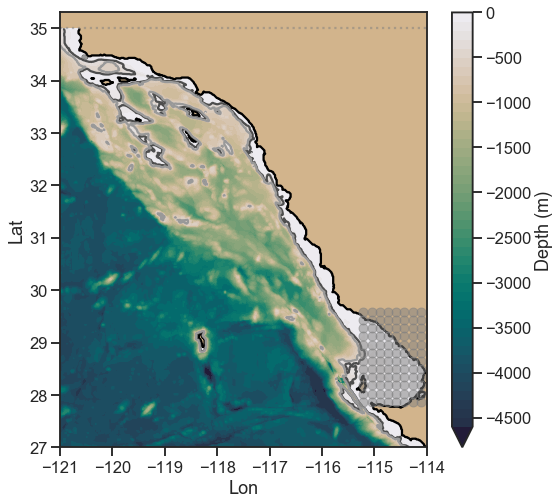

In [6]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(9,8))
ax.set_facecolor('tan')
pc = ax.contourf(LON,LAT,np.ma.masked_array(-depth, mask=mask_dep),50,
                 vmin=-5000, vmax=0, cmap=cmo.cm.rain_r, extend='min')
cb = plt.colorbar(pc, extend='min',label='depth / m')
cn = ax.contour(LON,LAT,depth, colors=['0','0.3','0.6'], levels=[0,250,500])

ax.plot(LON[55:170:10,370:450:10],LAT[55:170:10,370:450:10], 'o',color='0.5', alpha=0.5)

ax.axhline(35, linestyle=':', color='0.5', alpha=0.5)
cb.set_label('Depth (m)')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(239-360, 246-360)
ax.set_ylim(27,35.3)
ax.set_aspect(1)

### mke


In [7]:
dyn = mit.mnc.mnc_files(outdir+'dynVars.0000000000.t*.nc', layout='exch2')
dt = time[2]-time[1]

In [8]:
t0 = 0
tf = 143
nz1 = 0
nz2 = 20
nz3 = 55
t_fact = dt/(time[tf]-time[t0])

In [7]:
UU,VV = unstagger(dyn.variables['UVEL'][t0:tf,nz1,...],dyn.variables['VVEL'][t0:tf,nz1,...])
mask_exp = np.expand_dims(mask[nz1,...], axis=0)
mask_exp = mask_exp + np.zeros_like(UU)
u_mean1 = (t_fact)*np.nansum(np.ma.masked_array(UU, mask=mask_exp), axis=0)
v_mean1 = (t_fact)*np.nansum(np.ma.masked_array(VV, mask=mask_exp), axis=0)

UU,VV = unstagger(dyn.variables['UVEL'][t0:tf,nz2,...],dyn.variables['VVEL'][t0:tf,nz2,...])
mask_exp = np.expand_dims(mask[nz2,...], axis=0)
mask_exp = mask_exp + np.zeros_like(UU)
u_mean2 = (t_fact)*np.nansum(np.ma.masked_array(UU, mask=mask_exp), axis=0)
v_mean2 = (t_fact)*np.nansum(np.ma.masked_array(VV, mask=mask_exp), axis=0)

UU,VV = unstagger(dyn.variables['UVEL'][t0:tf,nz3,...],dyn.variables['VVEL'][t0:tf,nz3,...])
mask_exp = np.expand_dims(mask[nz3,...], axis=0)
mask_exp = mask_exp + np.zeros_like(UU)
u_mean3 = (t_fact)*np.nansum(np.ma.masked_array(UU, mask=mask_exp), axis=0)
v_mean3 = (t_fact)*np.nansum(np.ma.masked_array(VV, mask=mask_exp), axis=0)

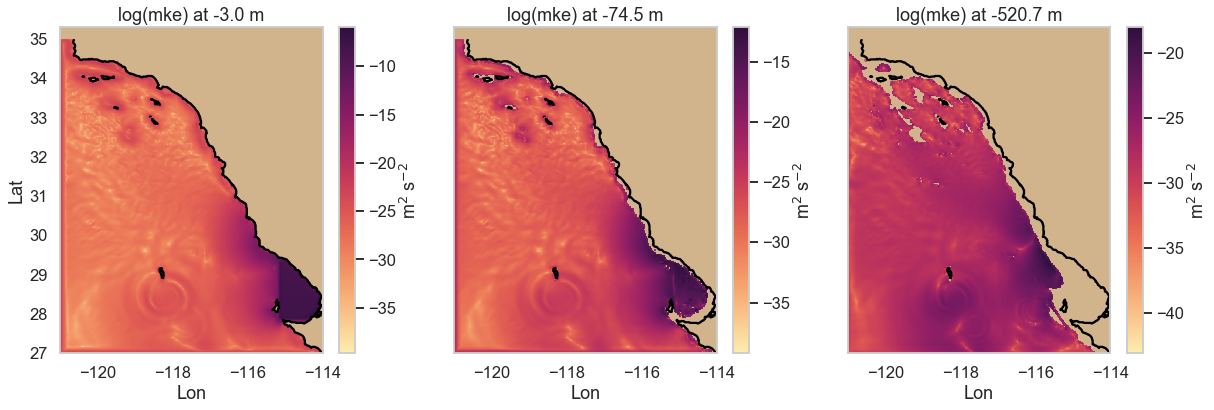

In [8]:
sns.set_context('talk')
sns.set_style('whitegrid')
fig1, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,6), sharey=True)

for ax,nz in zip((ax1,ax2,ax3),(nz1,nz2,nz3)):
    ax.set_facecolor('tan')
    ax.set_xlabel('Lon')
    ax.set_xlim(239-360, 246-360)
    ax.set_title('log(mke) at %1.1f m' %(Z[Zind[nz]]))

pc = ax1.pcolormesh(LON,LAT,np.log(0.5*(u_mean1[:,:]**2+v_mean1[:,:]**2)),
                   cmap=cmo.cm.matter)
plt.colorbar(pc, ax=ax1, label='m$^2$ s$^{-2}$')
cn = ax1.contour(LON,LAT,depth, colors=['0'], levels=[0])

pc = ax2.pcolormesh(LON,LAT,np.log(0.5*(u_mean2[:,:]**2+v_mean2[:,:]**2)),
                   cmap=cmo.cm.matter)
plt.colorbar(pc, ax=ax2, label='m$^2$ s$^{-2}$')
cn = ax2.contour(LON,LAT,depth, colors=['0'], levels=[0])

pc = ax3.pcolormesh(LON,LAT,np.log(0.5*(u_mean3[:,:]**2+v_mean3[:,:]**2)),
                   cmap=cmo.cm.matter)
plt.colorbar(pc, ax=ax3, label='m$^2$ s$^{-2}$')
cn = ax3.contour(LON,LAT,depth, colors=['0'], levels=[0])

ax1.set_ylabel('Lat')
ax1.set_ylim(27,35.3)

plt.show()

#### eke

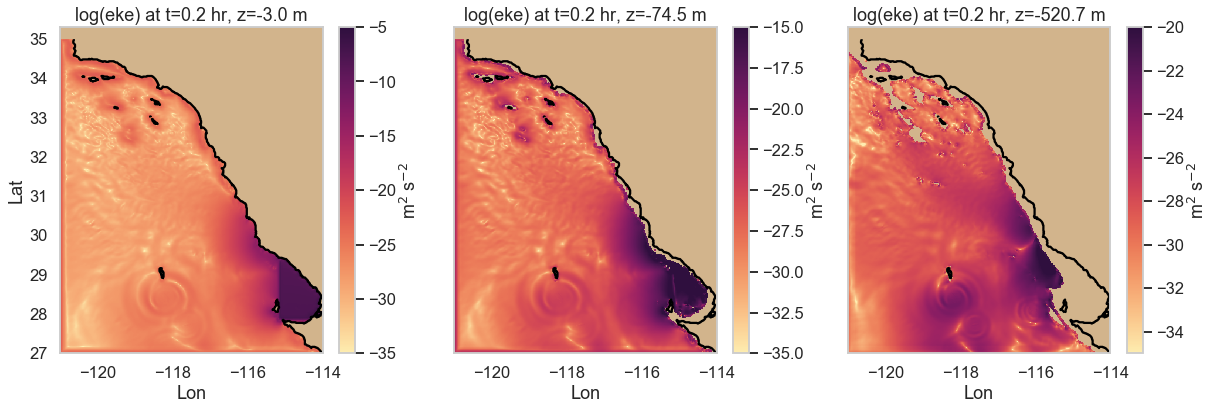

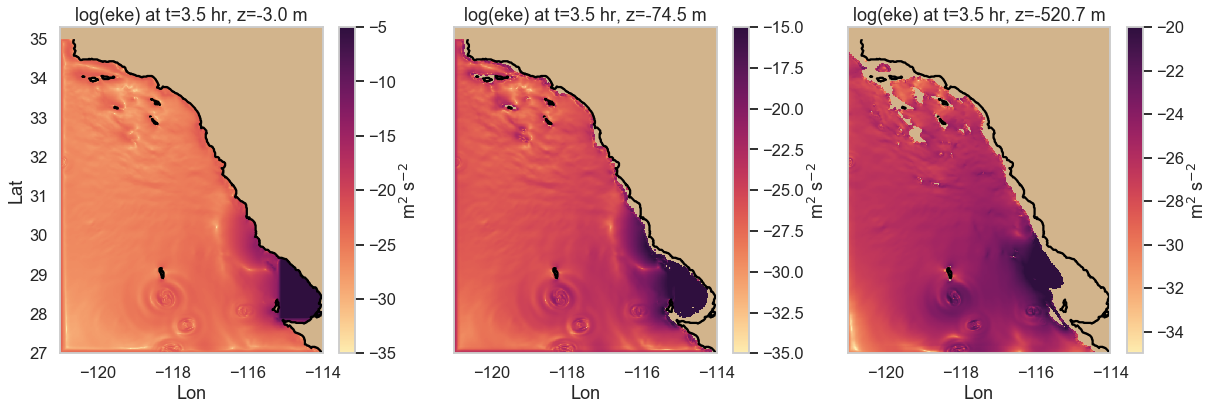

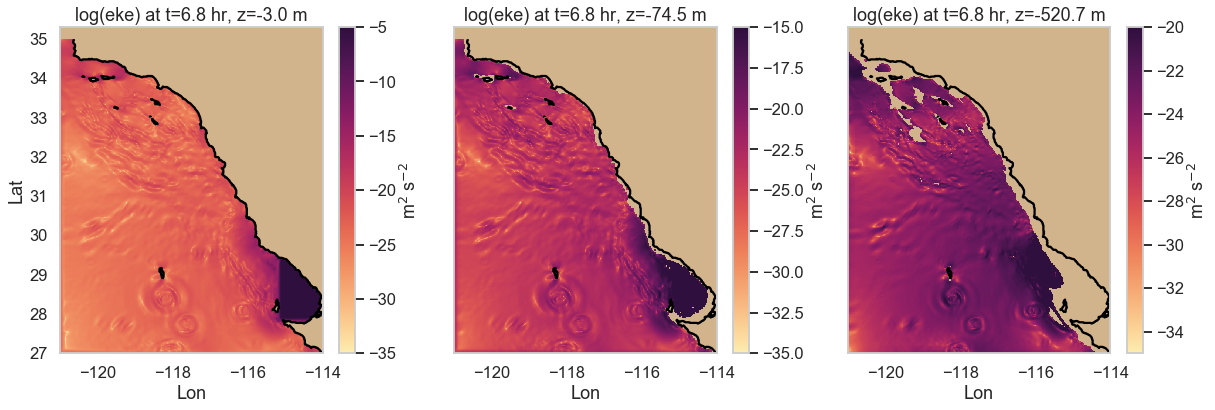

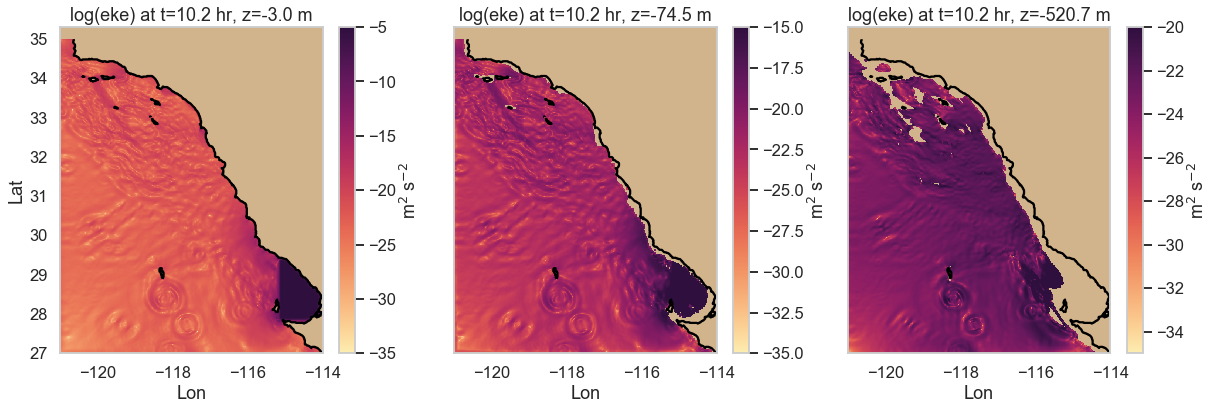

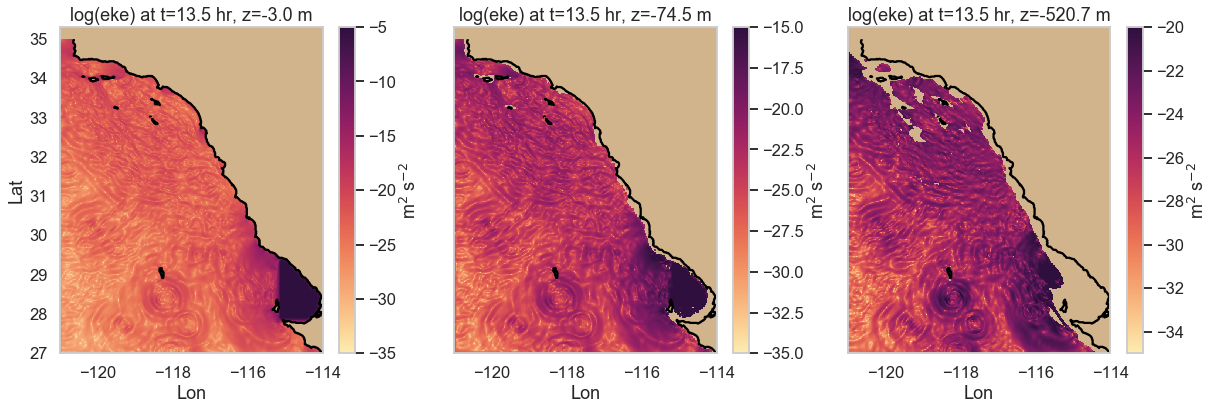

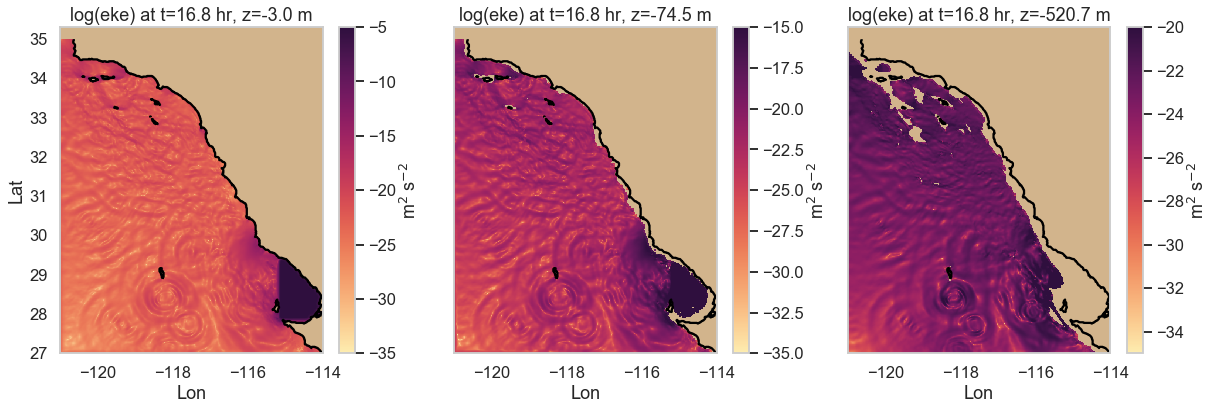

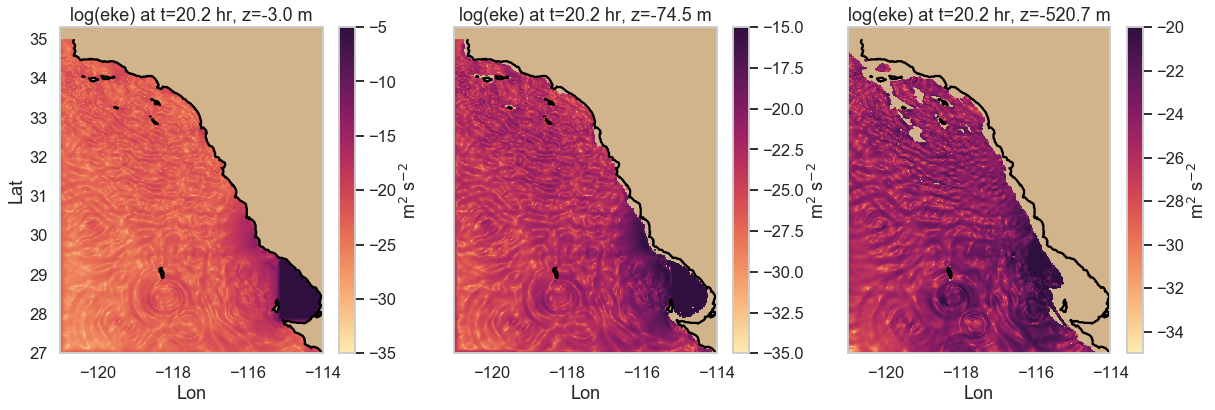

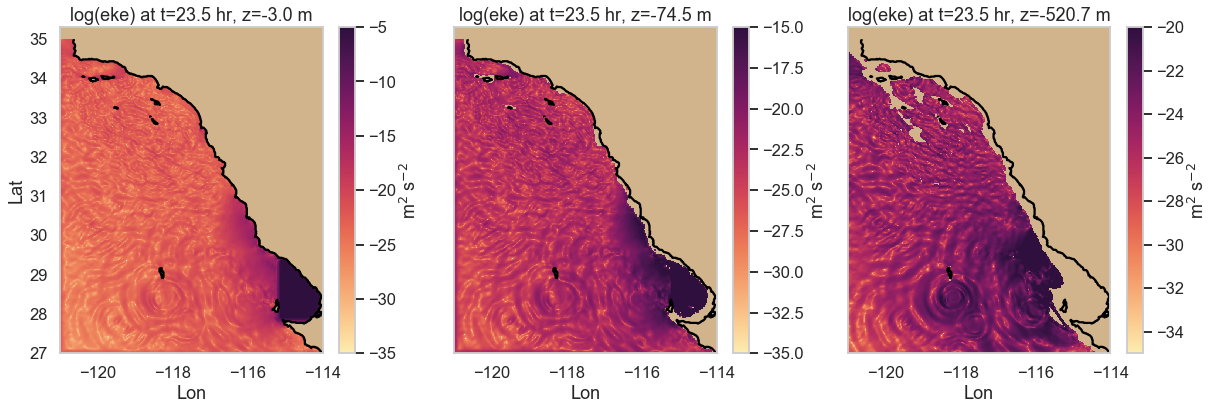

In [10]:
for tt in range(0,142,20):
    UU,VV = unstagger(dyn.variables['UVEL'][tt,nz1,...],dyn.variables['VVEL'][tt,nz1,...])
    u_var1 = np.ma.masked_array(UU, mask=mask[nz1,...])-u_mean1
    v_var1 = np.ma.masked_array(VV, mask=mask[nz1,...])-v_mean1

    UU,VV = unstagger(dyn.variables['UVEL'][tt,nz2,...],dyn.variables['VVEL'][tt,nz2,...])
    u_var2 = np.ma.masked_array(UU, mask=mask[nz2,...])-u_mean2
    v_var2 = np.ma.masked_array(VV, mask=mask[nz2,...])-v_mean2

    UU,VV = unstagger(dyn.variables['UVEL'][tt,nz3,...],dyn.variables['VVEL'][tt,nz3,...])
    u_var3 = np.ma.masked_array(UU, mask=mask[nz3,...])-u_mean3
    v_var3 = np.ma.masked_array(VV, mask=mask[nz3,...])-v_mean3
    sns.set_context('talk')
    sns.set_style('whitegrid')
    
    fig1, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,6), sharey=True)

    for ax,nz in zip((ax1,ax2,ax3),(nz1,nz2,nz3)):
        ax.set_facecolor('tan')
        ax.set_xlabel('Lon')
        ax.set_xlim(239-360, 246-360)
        ax.set_title('log(eke) at t=%1.1f hr, z=%1.1f m' %(time[tt]/3600,Z[Zind[nz]]))

    pc = ax1.pcolormesh(LON,LAT,np.log(0.5*(u_var1[:,:]**2+v_var1[:,:]**2)),
                       cmap=cmo.cm.matter, vmin=-35, vmax=-5)
    plt.colorbar(pc, ax=ax1, label='m$^2$ s$^{-2}$')
    cn = ax1.contour(LON,LAT,depth, colors=['0'], levels=[0])

    pc = ax2.pcolormesh(LON,LAT,np.log(0.5*(u_var2[:,:]**2+v_var2[:,:]**2)),
                       cmap=cmo.cm.matter, vmin=-35, vmax=-15)
    plt.colorbar(pc, ax=ax2, label='m$^2$ s$^{-2}$')
    cn = ax2.contour(LON,LAT,depth, colors=['0'], levels=[0])

    pc = ax3.pcolormesh(LON,LAT,np.log(0.5*(u_var3[:,:]**2+v_var3[:,:]**2)),
                       cmap=cmo.cm.matter, vmin=-35, vmax=-20)
    plt.colorbar(pc, ax=ax3, label='m$^2$ s$^{-2}$')
    cn = ax3.contour(LON,LAT,depth, colors=['0'], levels=[0])

    ax1.set_ylabel('Lat')
    ax1.set_ylim(27,35.3)

    plt.show()

#### Vertically integrated eke (top 500 m)

Takes forever to read in U and V fields...

In [44]:
nzf = 54

UU,VV = unstagger(dyn.variables['UVEL'][:,:nzf,...],dyn.variables['VVEL'][:,:nzf,...])
mask_exp = np.expand_dims(mask[:nzf,...], axis=0)
mask_exp = mask_exp + np.zeros_like(UU)

In [45]:
u_mean = (t_fact)*np.nansum(np.ma.masked_array(UU, mask=mask_exp), axis=0)
v_mean = (t_fact)*np.nansum(np.ma.masked_array(VV, mask=mask_exp), axis=0)

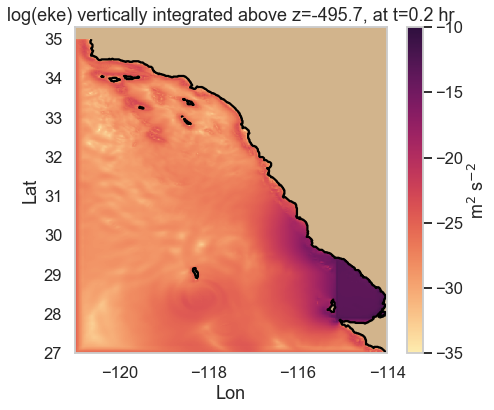

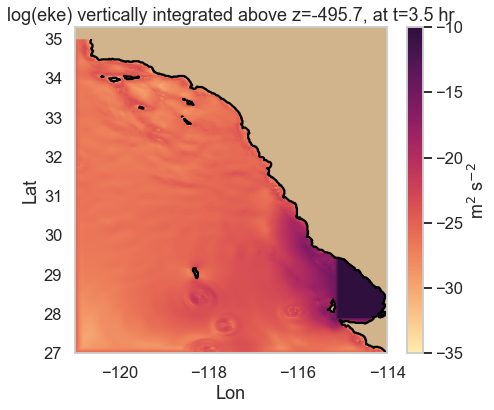

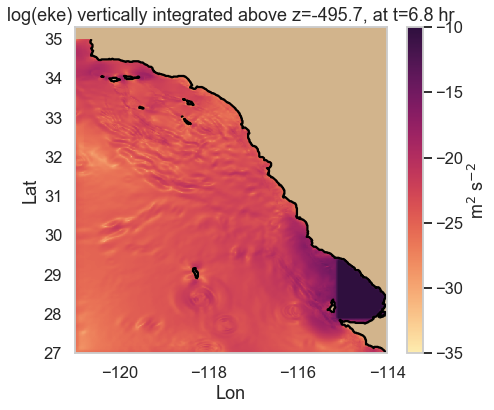

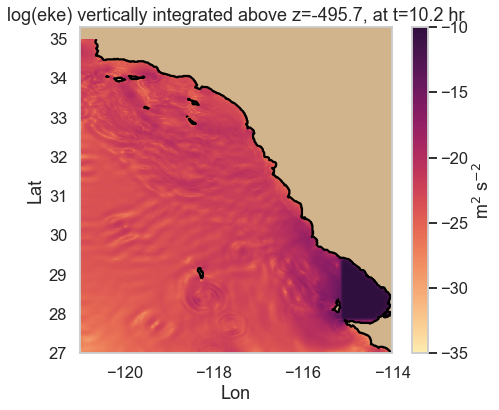

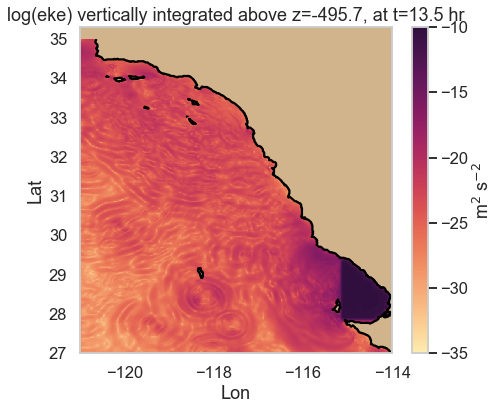

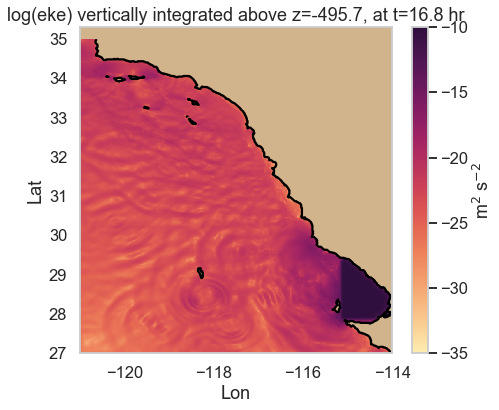

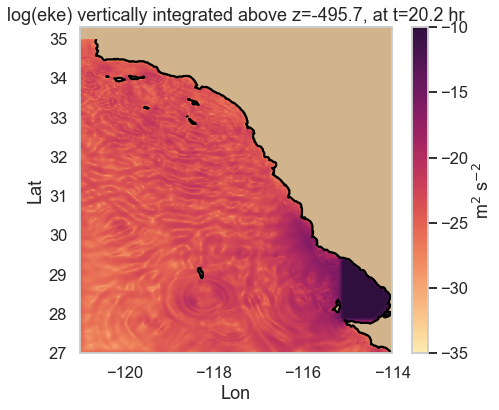

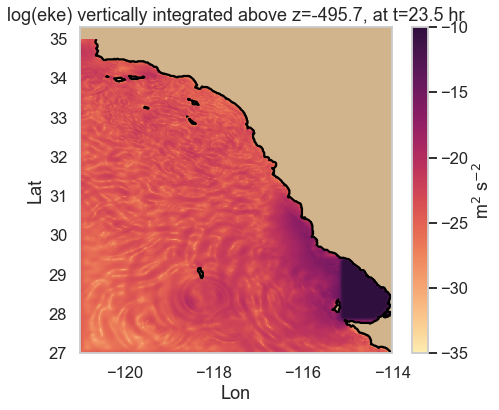

In [48]:
for tt in range(0,142,20):
    UU,VV = unstagger(dyn.variables['UVEL'][tt,:nzf,...],dyn.variables['VVEL'][tt,:nzf,...])
    mask_exp = np.expand_dims(mask[:nzf,...], axis=0)
    mask_exp = mask_exp + np.zeros_like(UU)
    
    u_var = np.ma.masked_array(UU, mask=mask[:nzf,...])-u_mean
    v_var = np.ma.masked_array(VV, mask=mask[:nzf,...])-v_mean
    
    drF_exp = np.expand_dims(np.expand_dims(drF[:nzf], axis=1),axis=1)
    drF_exp = drF_exp + np.zeros_like(UU)
    
    eke_zint = (-1/Z[Zind[nzf]])*np.nansum((0.5*(u_var[:,:,:]**2+v_var[:,:,:]**2))*drF_exp[:nzf], axis=0)
    
    sns.set_context('talk')
    sns.set_style('whitegrid')
    
    fig1, (ax1) = plt.subplots(1,1, figsize=(7,6), sharey=True)

    ax1.set_facecolor('tan')
    ax1.set_xlabel('Lon')
    ax1.set_xlim(239-360, 246-360)
    ax1.set_title('log(eke) vertically integrated above z=%1.1f, at t=%1.1f hr' %(Z[Zind[nzf]],
                                                                                 time[tt]/3600))

    pc = ax1.pcolormesh(LON,LAT,np.log(eke_zint),
                       cmap=cmo.cm.matter, vmin=-35, vmax=-10)
    plt.colorbar(pc, ax=ax1, label='m$^2$ s$^{-2}$')
    cn = ax1.contour(LON,LAT,depth, colors=['0'], levels=[0])
    
    ax1.set_ylabel('Lat')
    ax1.set_ylim(27,35.3)

    plt.show()

### Per region

SVB

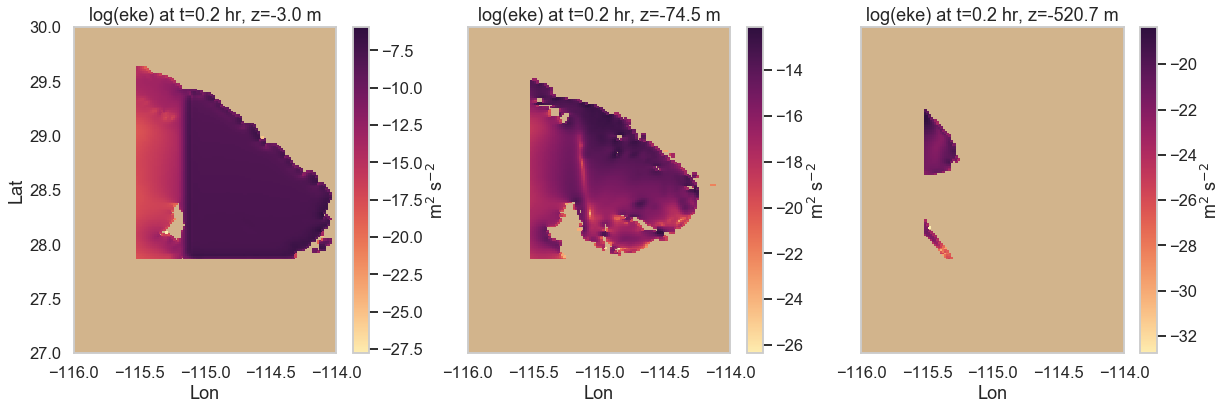

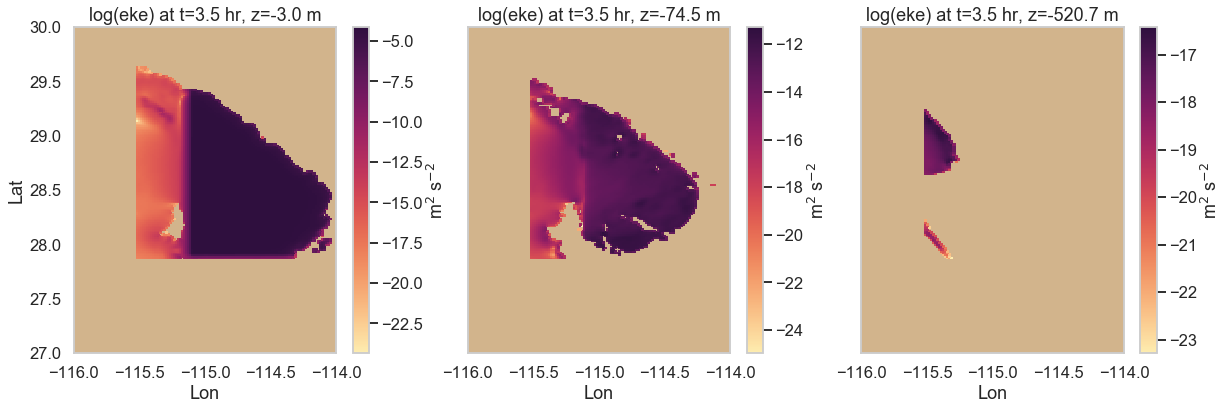

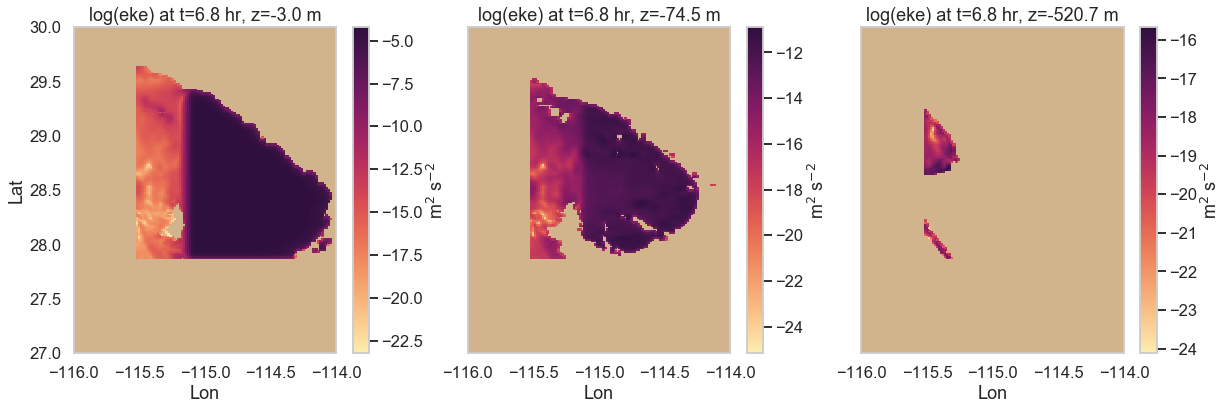

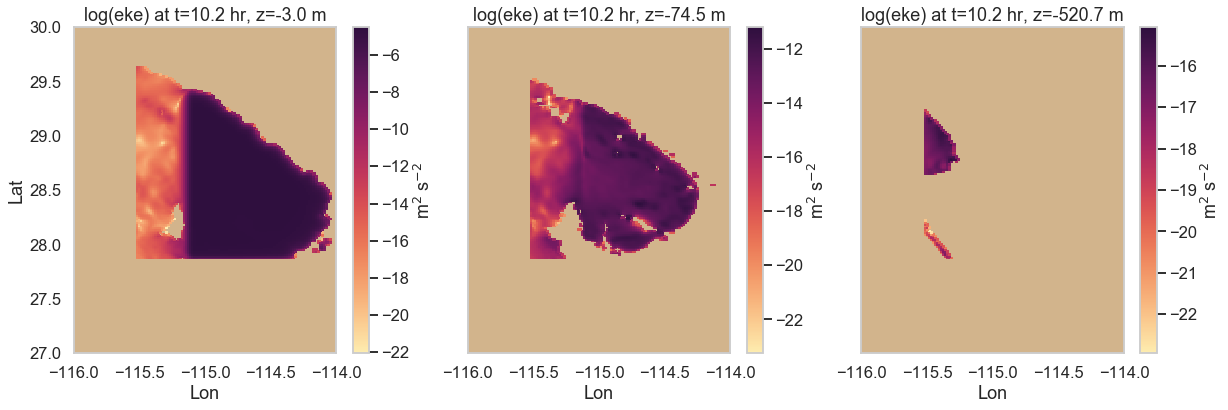

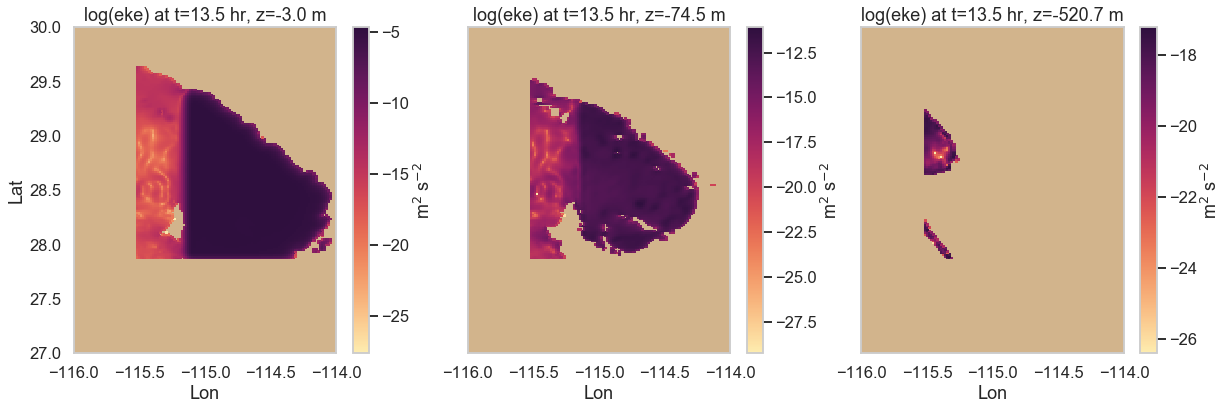

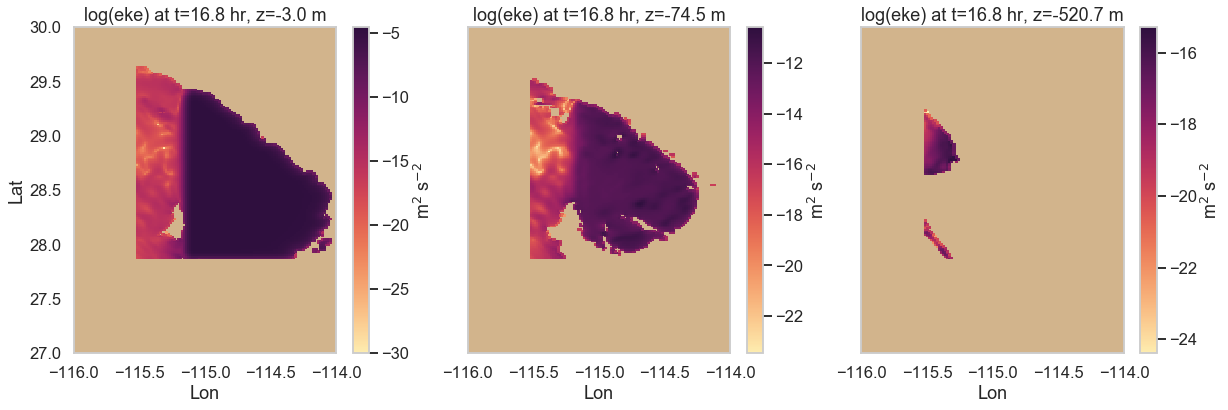

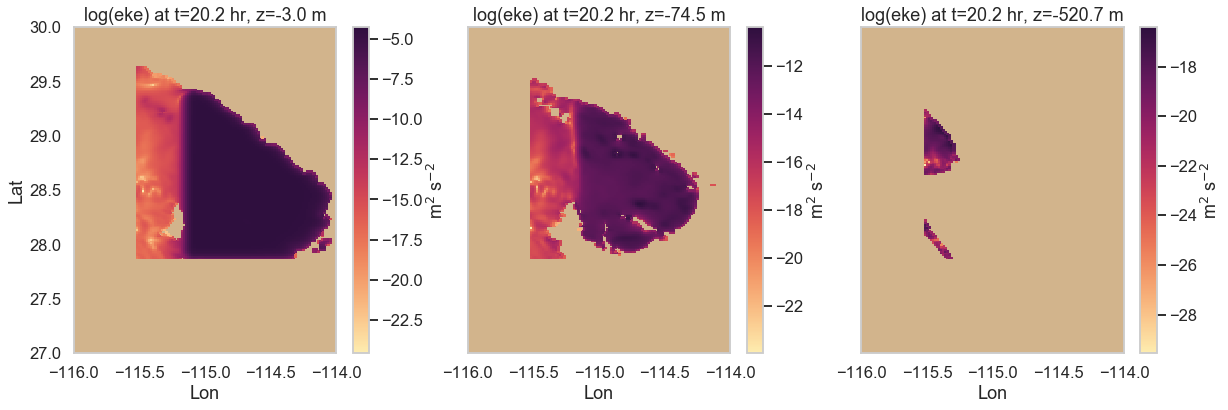

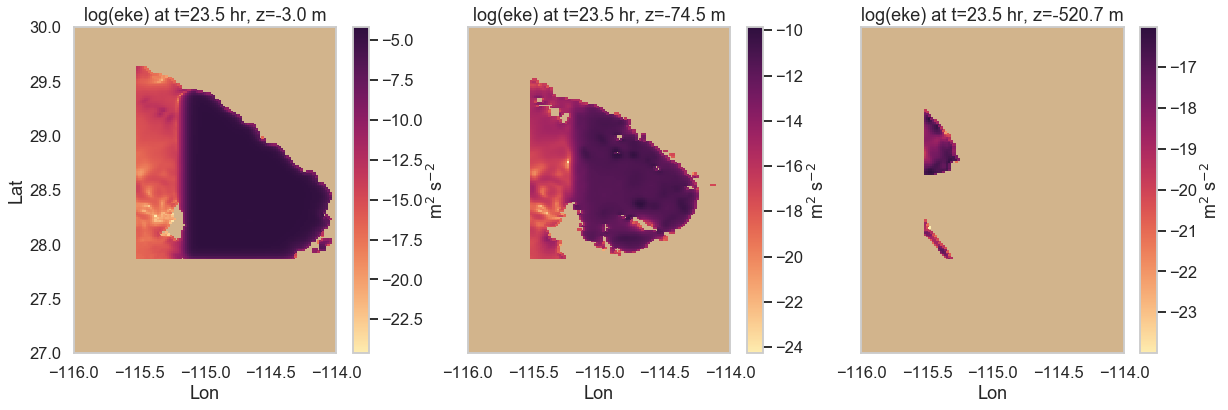

In [111]:
xi = 370
xf = 450
yi = 55
yf = 170
for tt in range(0,142,20):
    UU,VV = unstagger(dyn.variables['UVEL'][tt,nz1,yi:yf,xi:xf+1],dyn.variables['VVEL'][tt,nz1,yi:yf+1,xi:xf])
    u_var1 = np.ma.masked_array(UU, mask=mask[nz1,yi:yf,xi:xf])-u_mean1[yi:yf,xi:xf]
    v_var1 = np.ma.masked_array(VV, mask=mask[nz1,yi:yf,xi:xf])-v_mean1[yi:yf,xi:xf]

    UU,VV = unstagger(dyn.variables['UVEL'][tt,nz2,yi:yf,xi:xf+1],dyn.variables['VVEL'][tt,nz2,yi:yf+1,xi:xf])
    u_var2 = np.ma.masked_array(UU, mask=mask[nz2,yi:yf,xi:xf])-u_mean2[yi:yf,xi:xf]
    v_var2 = np.ma.masked_array(VV, mask=mask[nz2,yi:yf,xi:xf])-v_mean2[yi:yf,xi:xf]

    UU,VV = unstagger(dyn.variables['UVEL'][tt,nz3,yi:yf,xi:xf+1],dyn.variables['VVEL'][tt,nz3,yi:yf+1,xi:xf])
    u_var3 = np.ma.masked_array(UU, mask=mask[nz3,yi:yf,xi:xf])-u_mean3[yi:yf,xi:xf]
    v_var3 = np.ma.masked_array(VV, mask=mask[nz3,yi:yf,xi:xf])-v_mean3[yi:yf,xi:xf]
    sns.set_context('talk')
    sns.set_style('whitegrid')
    
    fig1, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,6), sharey=True)

    for ax,nz in zip((ax1,ax2,ax3),(nz1,nz2,nz3)):
        ax.set_facecolor('tan')
        ax.set_xlabel('Lon')
        ax.set_xlim(-116, -114)
        ax.set_title('log(eke) at t=%1.1f hr, z=%1.1f m' %(time[tt]/3600,Z[Zind[nz]]))

    pc = ax1.pcolormesh(LON[yi:yf,xi:xf],LAT[yi:yf,xi:xf],np.log(0.5*(u_var1[:,:]**2+v_var1[:,:]**2)),
                       cmap=cmo.cm.matter)
    plt.colorbar(pc, ax=ax1, label='m$^2$ s$^{-2}$')

    pc = ax2.pcolormesh(LON[yi:yf,xi:xf],LAT[yi:yf,xi:xf],np.log(0.5*(u_var2[:,:]**2+v_var2[:,:]**2)),
                       cmap=cmo.cm.matter)
    plt.colorbar(pc, ax=ax2, label='m$^2$ s$^{-2}$')

    pc = ax3.pcolormesh(LON[yi:yf,xi:xf],LAT[yi:yf,xi:xf],np.log(0.5*(u_var3[:,:]**2+v_var3[:,:]**2)),
                       cmap=cmo.cm.matter)
    plt.colorbar(pc, ax=ax3, label='m$^2$ s$^{-2}$')

    ax1.set_ylabel('Lat')
    ax1.set_ylim(27,30)

    plt.show()